## Импортируем модули.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras.layers import Dense

## Импортируем датасет после EDA_v01.

In [2]:
df_bp_nup = pd.read_csv('../data/processed/EDA_out_v01.csv')
df_bp_nup.head(1)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,-1.205452,0.725992,-6.973426e-16,-2.221491,4.517515,-8.512290e-15,-0.8607,-1.077783,1.121088,0.0,-0.387298,-0.912774,0.990555


## Создаем датафрейм для сравнения моделей.

In [3]:
df_poc = pd.DataFrame(columns=['Модуль упругости при растяжении', 'Прочность при растяжении', 'Соотношение матрица-наполнитель'])

## Определяем перечень столбцов данных и целей.

In [4]:
data_columns = list(df_bp_nup.columns)
target_elastic = ['Модуль упругости при растяжении, ГПа']
target_strength = ['Прочность при растяжении, МПа']
target_mfiller = ['Соотношение матрица-наполнитель']
data_columns

['Соотношение матрица-наполнитель',
 'Плотность, кг/м3',
 'модуль упругости, ГПа',
 'Количество отвердителя, м.%',
 'Содержание эпоксидных групп,%_2',
 'Температура вспышки, С_2',
 'Поверхностная плотность, г/м2',
 'Модуль упругости при растяжении, ГПа',
 'Прочность при растяжении, МПа',
 'Потребление смолы, г/м2',
 'Угол нашивки, град',
 'Шаг нашивки',
 'Плотность нашивки']

## Выбор типов моделей.

![title](/notebooks/notebook/images/EDA_v01_boxplot.PNG)

Т.к. коэффициенты корреляции имеют каскадные связи по параметрам, необходимо использовать модели:
    1. На основе Дерева решений RandomForest
    2. Нейронная сеть
"Соотношения матрица-наполнитель" - обучаем на нейронной сети (по заданию ВКР)
"Модуль упругости при растяжении", "Прочность при растяжении" - обучим на RandomFores, по причине параллельного обучения, а так же на нейронной сети для сравнения результатов.

#### Для подбора параметров случайного леса, зафиксируем следующие параметры:

In [5]:
rft_param_grid = {
    'n_estimators': [12, 24, 36], # Количество деревьев в лесу
    'max_features': ['auto', 'sqrt', 'log2'], # Ряд особенностей, которые следует учитывать при поиске лучшего сплита
    'max_depth' : [1, 3, 5, 7], # Максимальная глубина дерева.
    'min_samples_leaf': [1, 3, 5], # Минимальное количество выборок, необходимое для конечного узла.
    'criterion' :['squared_error']
}

#### Создадим функцию отрисовки

In [51]:
def plot_prediction(y_test, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(y_test, test_predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    lims = [0, 4]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

## "Модуль упругости при растяжении"

### Случайный лес

In [6]:
X_elastic = df_bp_nup[data_columns].drop(['Модуль упругости при растяжении, ГПа'], axis=1)
y_elastic = df_bp_nup[target_elastic]
X_elastic_train, X_elastic_test, y_elastic_train, y_elastic_test = train_test_split(X_elastic, y_elastic, train_size=0.7, random_state=42)

#### Подберем лучший параметр

In [7]:
GSCV_rft_elastic = RandomForestRegressor(random_state = 42)
GSCV_rft_elastic = GridSearchCV(estimator=GSCV_rft_elastic, param_grid=rft_param_grid, cv=10, verbose=2)
GSCV_rft_elastic.fit(X_elastic, y_elastic)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.2s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [1, 3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [12, 24, 36]},
             verbose=2)

In [8]:
pd.DataFrame(GSCV_rft_elastic.cv_results_).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024681,0.011105,0.004543,0.004662,squared_error,1,auto,1,12,"{'criterion': 'squared_error', 'max_depth': 1,...",...,0.793554,0.869524,0.877347,0.869728,0.863308,0.872714,0.872214,0.855071,0.028153,88


In [9]:
GSCV_rft_elastic.best_params_

{'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 12}

Параметры criterion, max_features, min_samples_leaf - по умолчанию

In [10]:
GSCV_rft_elastic.best_score_

1.0

#### Обучаем модель на лучших параметрах, фиксируем score-R2

In [11]:
rft_elastic = RandomForestRegressor(n_estimators=12, max_depth=3)
rft_elastic.fit(X_elastic_train, y_elastic_train)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_7516\1771654818.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rft_elastic.fit(X_elastic_train, y_elastic_train)


RandomForestRegressor(max_depth=3, n_estimators=12)

In [12]:
rft_predict_elastic = rft_elastic.predict(X_elastic_test)
rft_score_r2_elastic = r2_score(y_elastic_test, rft_predict_elastic)
rft_score_r2_elastic

1.0

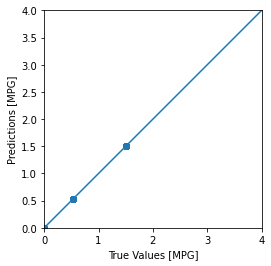

In [58]:
plot_prediction(y_elastic_test, rft_predict_elastic)

In [13]:
df_poc.loc['Случайный лес'] = np.nan
df_poc.loc[['Случайный лес'], ['Модуль упругости при растяжении']] = rft_score_r2_elastic

### Нейронная сеть

In [14]:
nrn_elastic = keras.Sequential([
    Dense(12, input_dim=12),
    Dense(12, activation='sigmoid'),
    Dense(12, activation='sigmoid'),
    Dense(1)
])
nrn_elastic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 12)                156       
                                                                 
 dense_3 (Dense)             (None, 1)                 13        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [15]:
nrn_elastic.compile(optimizer='adam', loss='mse', metrics='mae')
nrn_elastic.fit(X_elastic_train, y_elastic_train, epochs=10, validation_split=0.1)

Epoch 1/10
23/23 [==============================] - 1s 11ms/step - loss: 1.4856 - mae: 0.9742 - val_loss: 1.2903 - val_mae: 0.9640
Epoch 2/10
23/23 [==============================] - 0s 4ms/step - loss: 1.0826 - mae: 0.8946 - val_loss: 0.9620 - val_mae: 0.8518
Epoch 3/10
23/23 [==============================] - 0s 3ms/step - loss: 0.8786 - mae: 0.8250 - val_loss: 0.7848 - val_mae: 0.7612
Epoch 4/10
23/23 [==============================] - 0s 3ms/step - loss: 0.7564 - mae: 0.7637 - val_loss: 0.6703 - val_mae: 0.6940
Epoch 5/10
23/23 [==============================] - 0s 4ms/step - loss: 0.6473 - mae: 0.7033 - val_loss: 0.5592 - val_mae: 0.6342
Epoch 6/10
23/23 [==============================] - 0s 3ms/step - loss: 0.5282 - mae: 0.6335 - val_loss: 0.4402 - val_mae: 0.5636
Epoch 7/10
23/23 [==============================] - 0s 3ms/step - loss: 0.4037 - mae: 0.5522 - val_loss: 0.3282 - val_mae: 0.4853
Epoch 8/10
23/23 [==============================] - 0s 4ms/step - loss: 0.2935 - mae: 0.4

In [16]:
nrn_predict_elastic = nrn_elastic.predict(X_elastic_test)
nrn_score_r2_elastic = r2_score(y_elastic_test, nrn_predict_elastic)
nrn_score_r2_elastic

0.8574386065934718

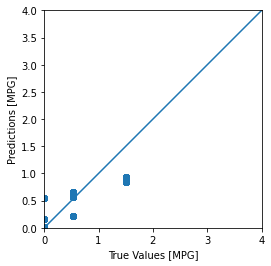

In [57]:
plot_prediction(y_elastic_test, nrn_predict_elastic)

In [17]:
df_poc.loc['Нейронная сеть'] = np.nan
df_poc.loc[['Нейронная сеть'], ['Модуль упругости при растяжении']] = nrn_score_r2_elastic

## "Прочность при растяжении"

### Случайный лес

In [18]:
X_strength = df_bp_nup[data_columns].drop(['Прочность при растяжении, МПа'], axis=1)
y_strength = df_bp_nup[target_strength]
X_strength_train, X_strength_test, y_strength_train, y_strength_test = train_test_split(X_strength, y_strength, train_size=0.7, random_state=42)

#### Подберем лучший параметр

In [19]:
GSCV_rft_strength = RandomForestRegressor(random_state = 42)
GSCV_rft_strength = GridSearchCV(estimator=GSCV_rft_strength, param_grid=rft_param_grid, cv=10, verbose=2)
GSCV_rft_strength.fit(X_strength, y_strength)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed whe

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [1, 3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [12, 24, 36]},
             verbose=2)

In [20]:
pd.DataFrame(GSCV_rft_strength.cv_results_).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021254,0.006859,0.002661,0.003153,squared_error,1,auto,1,12,"{'criterion': 'squared_error', 'max_depth': 1,...",...,0.934132,0.939164,0.915635,0.925753,0.932631,0.905551,0.946362,0.932697,0.013365,88


In [21]:
GSCV_rft_strength.best_params_

{'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 12}

Параметры criterion, max_features, min_samples_leaf - по умолчанию

In [22]:
GSCV_rft_strength.best_score_

1.0

#### Обучаем модель на лучших параметрах, фиксируем score-R2

In [23]:
rft_strength = RandomForestRegressor(n_estimators=12, max_depth=3)
rft_strength.fit(X_strength_train, y_strength_train)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_7516\2829378535.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rft_strength.fit(X_strength_train, y_strength_train)


RandomForestRegressor(max_depth=3, n_estimators=12)

In [24]:
rft_predict_strength = rft_strength.predict(X_strength_test)
rft_score_r2_strength = r2_score(y_strength_test, rft_predict_strength)
rft_score_r2_strength

1.0

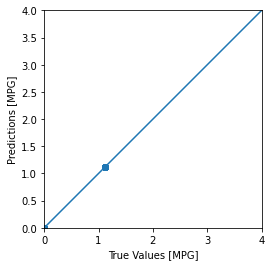

In [56]:
plot_prediction(y_strength_test, rft_predict_strength)

In [25]:
df_poc.loc[['Случайный лес'], ['Прочность при растяжении']] = rft_score_r2_strength

### Нейронная сеть

In [26]:
nrn_strength = keras.Sequential([
    Dense(12, input_dim=12),
    Dense(12, activation='sigmoid'),
    Dense(12, activation='sigmoid'),
    Dense(1)
])
nrn_strength.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12)                156       
                                                                 
 dense_5 (Dense)             (None, 12)                156       
                                                                 
 dense_6 (Dense)             (None, 12)                156       
                                                                 
 dense_7 (Dense)             (None, 1)                 13        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [27]:
nrn_strength.compile(optimizer='adam', loss='mse', metrics='mae')
nrn_strength.fit(X_strength_train, y_strength_train, epochs=10, validation_split=0.1)

Epoch 1/10
23/23 [==============================] - 1s 10ms/step - loss: 1.0437 - mae: 0.9032 - val_loss: 0.9223 - val_mae: 0.8199
Epoch 2/10
23/23 [==============================] - 0s 4ms/step - loss: 0.9344 - mae: 0.8542 - val_loss: 0.8711 - val_mae: 0.8052
Epoch 3/10
23/23 [==============================] - 0s 4ms/step - loss: 0.8578 - mae: 0.8191 - val_loss: 0.7958 - val_mae: 0.7665
Epoch 4/10
23/23 [==============================] - 0s 3ms/step - loss: 0.7674 - mae: 0.7753 - val_loss: 0.6992 - val_mae: 0.7244
Epoch 5/10
23/23 [==============================] - 0s 4ms/step - loss: 0.6587 - mae: 0.7188 - val_loss: 0.5873 - val_mae: 0.6702
Epoch 6/10
23/23 [==============================] - 0s 3ms/step - loss: 0.5363 - mae: 0.6457 - val_loss: 0.4645 - val_mae: 0.5996
Epoch 7/10
23/23 [==============================] - 0s 3ms/step - loss: 0.4135 - mae: 0.5601 - val_loss: 0.3485 - val_mae: 0.5176
Epoch 8/10
23/23 [==============================] - 0s 4ms/step - loss: 0.3063 - mae: 0.4

In [28]:
nrn_predict_strength = nrn_strength.predict(X_strength_test)
nrn_score_r2_strength = r2_score(y_strength_test, nrn_predict_strength)
nrn_score_r2_strength

0.8491054336951268

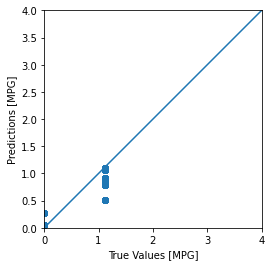

In [54]:
plot_prediction(y_strength_test, nrn_predict_strength)

In [29]:
df_poc.loc[['Нейронная сеть'], ['Прочность при растяжении']] = nrn_score_r2_strength

## "Соотношение матрица-наполнитель"

### Случайный лес

In [30]:
X_mfiller = df_bp_nup[data_columns].drop(['Соотношение матрица-наполнитель'], axis=1)
y_mfiller = df_bp_nup[target_mfiller]
X_mfiller_train, X_mfiller_test, y_mfiller_train, y_mfiller_test = train_test_split(X_mfiller, y_mfiller, train_size=0.7, random_state=42)

#### Подберем лучший параметр

In [31]:
GSCV_rft_mfiller = RandomForestRegressor(random_state = 42)
GSCV_rft_mfiller = GridSearchCV(estimator=GSCV_rft_mfiller, param_grid=rft_param_grid, cv=10, verbose=2)
GSCV_rft_mfiller.fit(X_mfiller, y_mfiller)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_lea

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed


[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed


[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=1, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=3, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.4s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=sqrt, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=1, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squar

d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=3, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=12; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=24; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\prj\mgtu_ds_u4\venv\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed whe

[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, max_features=log2, min_samples_leaf=5, n_estimators=36; total time=   0.0s


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [1, 3, 5, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [12, 24, 36]},
             verbose=2)

In [32]:
pd.DataFrame(GSCV_rft_mfiller.cv_results_).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021665,0.006445,0.00359,0.004557,squared_error,1,auto,1,12,"{'criterion': 'squared_error', 'max_depth': 1,...",...,0.294058,0.313264,0.334554,0.26384,0.410962,0.314064,0.135742,0.295915,0.072627,106


In [33]:
GSCV_rft_mfiller.best_params_

{'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 36}

Параметры criterion, max_features, min_samples_leaf - по умолчанию

In [34]:
GSCV_rft_mfiller.best_score_

0.9997947644577874

#### Обучаем модель на лучших параметрах, фиксируем score-R2

In [35]:
rft_mfiller = RandomForestRegressor(n_estimators=36, max_depth=7)
rft_mfiller.fit(X_mfiller_train, y_mfiller_train)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_7516\3020863134.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rft_mfiller.fit(X_mfiller_train, y_mfiller_train)


RandomForestRegressor(max_depth=7, n_estimators=36)

In [36]:
rft_predict_mfiller = rft_mfiller.predict(X_mfiller_test)
rft_score_r2_mfiller = r2_score(y_mfiller_test, rft_predict_mfiller)
rft_score_r2_mfiller

0.9999784987657135

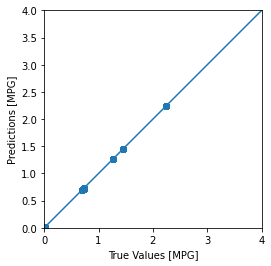

In [53]:
plot_prediction(y_mfiller_test, rft_predict_mfiller)

In [37]:
df_poc.loc[['Случайный лес'], ['Соотношение матрица-наполнитель']] = rft_score_r2_mfiller

### Нейронная сеть

In [38]:
nrn_mfiller = keras.Sequential([
    Dense(12, input_dim=12),
    Dense(12, activation='sigmoid'),
    Dense(12, activation='sigmoid'),
    Dense(12, activation='sigmoid'),
    Dense(1)
])
nrn_mfiller.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 12)                156       
                                                                 
 dense_9 (Dense)             (None, 12)                156       
                                                                 
 dense_10 (Dense)            (None, 12)                156       
                                                                 
 dense_11 (Dense)            (None, 12)                156       
                                                                 
 dense_12 (Dense)            (None, 1)                 13        
                                                                 
Total params: 637
Trainable params: 637
Non-trainable params: 0
_________________________________________________________________


In [39]:
nrn_mfiller.compile(optimizer='adam', loss='mse', metrics='mae')
nrn_mfiller.fit(X_mfiller_train, y_mfiller_train, epochs=70, validation_split=0.1)

Epoch 1/70
23/23 [==============================] - 1s 12ms/step - loss: 1.3581 - mae: 0.9669 - val_loss: 1.4124 - val_mae: 0.9953
Epoch 2/70
23/23 [==============================] - 0s 5ms/step - loss: 1.0955 - mae: 0.8541 - val_loss: 1.1877 - val_mae: 0.8950
Epoch 3/70
23/23 [==============================] - 0s 4ms/step - loss: 0.9900 - mae: 0.7971 - val_loss: 1.1010 - val_mae: 0.8483
Epoch 4/70
23/23 [==============================] - 0s 5ms/step - loss: 0.9659 - mae: 0.7786 - val_loss: 1.0656 - val_mae: 0.8297
Epoch 5/70
23/23 [==============================] - 0s 4ms/step - loss: 0.9488 - mae: 0.7695 - val_loss: 1.0489 - val_mae: 0.8211
Epoch 6/70
23/23 [==============================] - 0s 3ms/step - loss: 0.9319 - mae: 0.7600 - val_loss: 1.0368 - val_mae: 0.8131
Epoch 7/70
23/23 [==============================] - 0s 4ms/step - loss: 0.9125 - mae: 0.7518 - val_loss: 1.0121 - val_mae: 0.8028
Epoch 8/70
23/23 [==============================] - 0s 4ms/step - loss: 0.8886 - mae: 0.7

In [40]:
nrn_predict_mfiller = nrn_mfiller.predict(X_mfiller_test)
nrn_score_r2_mfiller = r2_score(y_mfiller_test, nrn_predict_mfiller)
nrn_score_r2_mfiller

0.9670674288283758

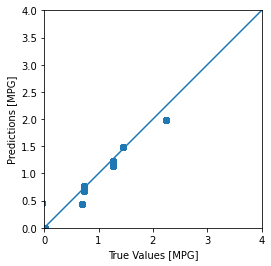

In [52]:
plot_prediction(y_mfiller_test, nrn_predict_mfiller)

In [41]:
df_poc.loc[['Нейронная сеть'], ['Соотношение матрица-наполнитель']] = nrn_score_r2_mfiller

In [42]:
df_poc.head(5)

,Модуль упругости при растяжении,Прочность при растяжении,Соотношение матрица-наполнитель
Случайный лес,1.000000,1.000000,0.999978
Нейронная сеть,0.857439,0.849105,0.967067


Случайный лес показал лучшие результаты, поэтому сохраним модели для использования в продакшн. Для "Соотношение матрица-наполнитель" по условиям задания ВКР сохраним нейронную сеть.

## Сохраняем модели

In [66]:
pickle.dump(rft_elastic, open('../model/rft_elastic_v01.pkl','wb'))

In [67]:
pickle.dump(rft_strength, open('../model/rft_strength_v01.pkl','wb'))

In [68]:
nrn_mfiller.save('../model/nrn_mfiller_v01')

INFO:tensorflow:Assets written to: ../data/processed/nrn_mfiller_v01\assets


## Вывод:
    1. Произведен поиск гиперпараметров модели по сетке, с перекресной проверкой, количество блоков=10.
    2. Модели обучились с высокими score ~ 1.
    3. "Модуль упругости при растяжении" - сохранена модель Случайного леса
    4. "Прочность при растяжении" - сохранена модель Случайного леса
    5. "Соотношение матрица-наполнитель" - сохранена модель Нейронной сети